# IMDA Dataset processing

In [1]:
import os
import re
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore')

## load results

In [2]:
llm_result_df_1 = pd.read_excel("../data/processed/IMDA_original1_V3b_gpt_0906_900_ra.xlsx")
llm_result_df = pd.read_excel("../data/processed/IMDA_sesson2_V3b_gpt_0912_ra.xlsx")
print(llm_result_df_1.shape)
print(llm_result_df.shape)
llm_result_df_1[['file_name','x_min', 'text','GPT4o']].head()
llm_result_df = pd.concat([llm_result_df_1,llm_result_df])
llm_result_df[['file_name','x_min', 'text','GPT4o']].head()

(79187, 14)
(99561, 14)


,file_name,x_min,text,GPT4o
0,app_1049_0014_phnd_cc-ins.TextGrid,30.48062,[ah] I see okay (uh) could I have your contact...,0.30
1,app_1049_5098_phnd_cc-ins.TextGrid,34.69394,nine six three eight six three eight eight,0.00
2,app_1049_0014_phnd_cc-ins.TextGrid,40.57225,okay sure so you mentioned that (uh) (uh) your...,0.15
3,app_1049_5098_phnd_cc-ins.TextGrid,47.65169,yes,0.15
4,app_1049_0014_phnd_cc-ins.TextGrid,48.62819,(mm) okay for two we have (uh) two models two ...,0.15


In [16]:
llm_result_df[(llm_result_df['word_count']<20) & (llm_result_df['qualified_for_sentiment'])][['text','GPT4o','explanation']].\
groupby('GPT4o').apply(lambda x: x.sample(n=1, random_state=42)).reset_index(drop=True).to_csv("../temp.csv",index=False)

In [14]:
llm_result_df.columns 

Index(['file_name', 'session_id', 'speaker_id', 'speaker_type', 'dialog_type',
       'x_min', 'x_max', 'text', 'cleaned_text_for_sentiment', 'word_count',
       'duration', 'qualified_for_sentiment', 'GPT4o', 'explanation'],
      dtype='object')

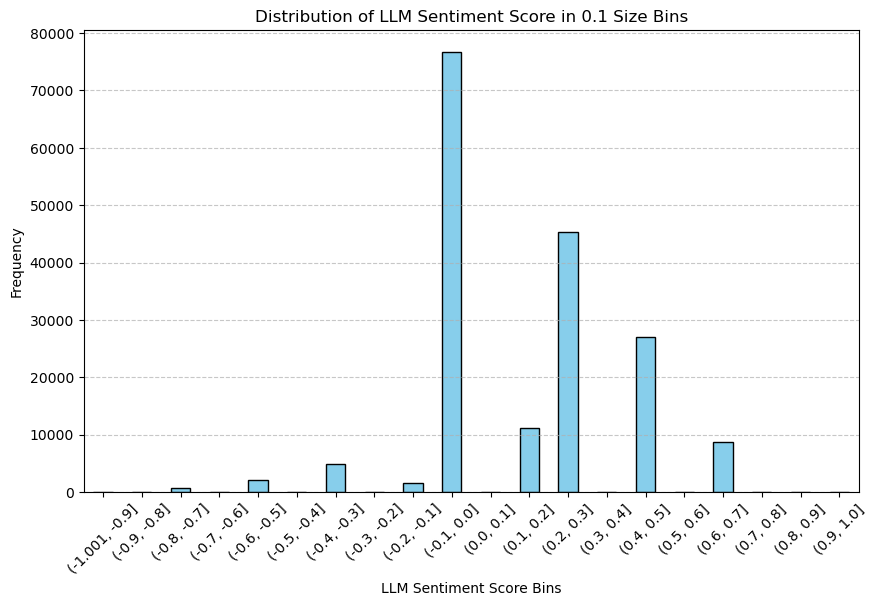

GPT4o
(-1.001, -0.9]        6
(-0.9, -0.8]          2
(-0.8, -0.7]        738
(-0.7, -0.6]          0
(-0.6, -0.5]       2187
(-0.5, -0.4]          0
(-0.4, -0.3]       4978
(-0.3, -0.2]          0
(-0.2, -0.1]       1657
(-0.1, 0.0]       76675
(0.0, 0.1]            0
(0.1, 0.2]        11210
(0.2, 0.3]        45399
(0.3, 0.4]            0
(0.4, 0.5]        27061
(0.5, 0.6]            0
(0.6, 0.7]         8781
(0.7, 0.8]            2
(0.8, 0.9]            1
(0.9, 1.0]           51
Name: count, dtype: int64


In [8]:
import matplotlib.pyplot as plt

# Calculate binning of 'final_sentiment_score' in bins of size 0.1
bin_counts = pd.cut(llm_result_df['GPT4o'], bins=[i/10 for i in range(-10, 11)], include_lowest=True).value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of LLM Sentiment Score in 0.1 Size Bins')
plt.xlabel('LLM Sentiment Score Bins')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display the bin counts
print(bin_counts)

In [3]:
rule_based_result_df = pd.read_excel("../data/processed/IMDA_V2_Sentiment_label_0812.xlsx")
rule_based_result_df = rule_based_result_df.drop(columns=['Unnamed: 0','Manual','Unnamed: 35'])
rule_based_result_df = rule_based_result_df.fillna(0)
rule_based_result_df = rule_based_result_df.drop_duplicates(subset=['cleaned_text_for_sentiment'])
rule_based_result_df = rule_based_result_df.drop(columns=['V-1', 'T-1', 'S-1'])
rule_based_result_df.head()

,file_name,session_id,speaker_id,speaker_type,dialog_type,x_min,x_max,text,cleaned_text_for_sentiment,word_count,...,V-6,T-6,S-6,V-8,T-8,S-8,V-9,T-9,S-9,processed_text
0,app_0683_0013_phnd_cc-bnk.TextGrid,683,13,agent,bank,2.48,5.35,hi this is A B C bank how can I help you,hi this is A B C bank how can I help you,12,...,0.4019,0.0,0.0,0.4019,0.0,0.0,0.4019,0.0,0.0,hi be A B C bank how can help
1,app_0683_4366_phnd_cc-bnk.TextGrid,683,4366,client,bank,5.35,15.42,hi my name is john (uh) I'm calling in with in...,hi my name is john (uh) I'm calling in with in...,20,...,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,hi name be john call in with in regard of enqu...
2,app_0683_0013_phnd_cc-bnk.TextGrid,683,13,agent,bank,17.15,23.55,ya our bank (uh) do give out ya our bank does ...,ya our bank (uh) do give out ya our bank does ...,9,...,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,our bank do give out our bank do give out home...
3,app_0683_4366_phnd_cc-bnk.TextGrid,683,4366,client,bank,17.20,20.05,sorry does does your bank give out home loans,sorry does does your bank give out home loans,8,...,-0.0772,-0.5,0.0,-0.0772,-0.5,0.0,-0.0772,-0.5,0.0,sorry do do bank give out home loan
4,app_0683_4366_phnd_cc-bnk.TextGrid,683,4366,client,bank,23.28,27.41,[oh] ya probably I can give you some informati...,[oh] ya probably I can give you some informati...,11,...,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,probably can give some information on on side


In [4]:
merged_df = pd.merge(llm_result_df[['file_name','x_min', 'GPT4o', 'explanation' ]], rule_based_result_df, on=['file_name', 'x_min'], how='right')
print(merged_df.shape)
print(merged_df.columns)
merged_df[[ 'GPT4o', 'V-2', 'V-3', 'V-5', 'V-6', 'V-8', 
               'T-2','T-3', 'T-5','T-6','T-8', 
               'S-3', 'S-2','S-5','S-6','S-8']].corr().round(3)

(84495, 33)
Index(['file_name', 'x_min', 'GPT4o', 'explanation', 'session_id',
       'speaker_id', 'speaker_type', 'dialog_type', 'x_max', 'text',
       'cleaned_text_for_sentiment', 'word_count', 'duration',
       'qualified_for_sentiment', 'V-2', 'T-2', 'S-2', 'V-3', 'T-3', 'S-3',
       'V-5', 'T-5', 'S-5', 'V-6', 'T-6', 'S-6', 'V-8', 'T-8', 'S-8', 'V-9',
       'T-9', 'S-9', 'processed_text'],
      dtype='object')


,GPT4o,V-2,V-3,V-5,V-6,V-8,T-2,T-3,T-5,T-6,T-8,S-3,S-2,S-5,S-6,S-8
GPT4o,1.000,0.250,0.218,0.217,0.249,0.249,0.147,0.119,0.119,0.152,0.152,0.186,0.183,0.186,0.175,0.176
V-2,0.250,1.000,0.891,0.889,0.985,0.984,0.386,0.368,0.368,0.389,0.389,0.235,0.251,0.226,0.204,0.206
V-3,0.218,0.891,1.000,0.998,0.890,0.890,0.364,0.413,0.413,0.366,0.366,0.252,0.201,0.243,0.153,0.154
V-5,0.217,0.889,0.998,1.000,0.889,0.889,0.364,0.413,0.413,0.366,0.366,0.252,0.201,0.244,0.152,0.154
V-6,0.249,0.985,0.890,0.889,1.000,0.999,0.383,0.366,0.366,0.388,0.388,0.235,0.250,0.227,0.207,0.210
V-8,0.249,0.984,0.890,0.889,0.999,1.000,0.383,0.366,0.366,0.388,0.388,0.235,0.250,0.226,0.207,0.209
T-2,0.147,0.386,0.364,0.364,0.383,0.383,1.000,0.878,0.878,0.982,0.982,0.209,0.207,0.218,0.195,0.201
T-3,0.119,0.368,0.413,0.413,0.366,0.366,0.878,1.000,0.999,0.882,0.882,0.209,0.182,0.219,0.168,0.173
T-5,0.119,0.368,0.413,0.413,0.366,0.366,0.878,0.999,1.000,0.882,0.882,0.209,0.182,0.219,0.168,0.173
T-6,0.152,0.389,0.366,0.366,0.388,0.388,0.982,0.882,0.882,1.000,1.000,0.207,0.206,0.215,0.196,0.202


In [5]:
# Extracting the VADER, TextBlob, and Stanza columns for comparison
'''CONFIGURABLE'''
vader_columns = ['V-2', 'V-3'] # [col for col in merged_df.columns if col.startswith('V-')]
textblob_columns = ['T-2', 'T-3'] # [col for col in merged_df.columns if col.startswith('T-')]
stanza_columns = ['S-2', 'S-3', 'S-5' ,'S-6','S-8']  #[col for col in merged_df.columns if col.startswith('S-')]

# Define the sentiment classification function based on the provided thresholds
def classify_sentiment_vader(score):
    if -0.05 <= score <= 0.5:
        return 'neutral'
    elif score > 0.5:
        return 'positive'
    else:
        return 'negative'

def classify_sentiment_textblob(score):
    if -0.05 <= score <= 0.3:
        return 'neutral'
    elif score > 0.3:
        return 'positive'
    else:
        return 'negative'

def classify_sentiment_stanza(score):
    # Since no specific threshold is provided, let's assume a default for demonstration
    if -0.05 <= score <= 0.05:
        return 'neutral'
    elif score > 0.05:
        return 'positive'
    else:
        return 'negative'

# Apply classification to each sentiment analysis method
for col in vader_columns:
    merged_df[f'{col}_sentiment'] = merged_df[col].apply(classify_sentiment_vader)

for col in textblob_columns:
    merged_df[f'{col}_sentiment'] = merged_df[col].apply(classify_sentiment_textblob)

for col in stanza_columns:
    merged_df[f'{col}_sentiment'] = merged_df[col].apply(classify_sentiment_stanza)


### Plots

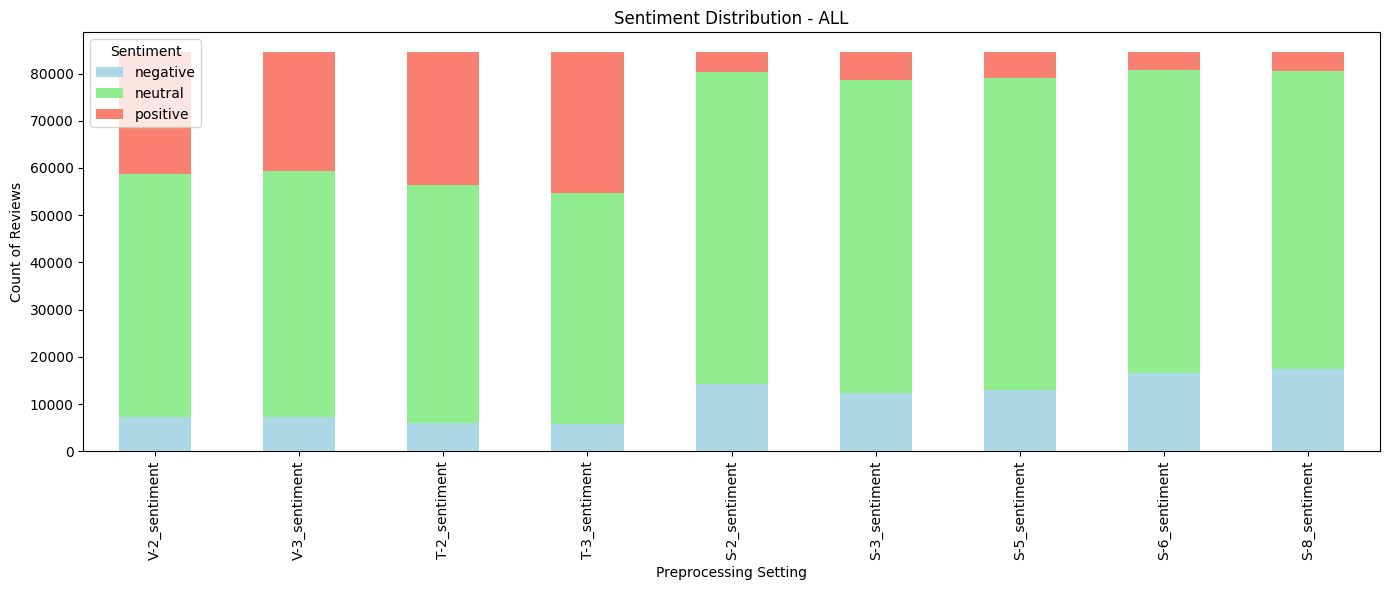

In [6]:
import matplotlib.pyplot as plt
# Calculate the sentiment distribution for each method
distribution = merged_df[[f'{col}_sentiment' for col in vader_columns +textblob_columns + stanza_columns ]].apply(pd.Series.value_counts)

# Plot the sentiment distribution for VADER
distribution.T.plot(kind='bar', stacked=True, figsize=(14, 6), color=['lightblue', 'lightgreen', 'salmon'])
plt.title('Sentiment Distribution - ALL')
plt.xlabel('Preprocessing Setting')
plt.ylabel('Count of Reviews')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

## Rule based voting

In [7]:
# Map the sentiment labels to integers
label_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
# Apply classification to each sentiment analysis method
for col in vader_columns + textblob_columns + stanza_columns:
    merged_df[f'{col}_vote'] = merged_df[col + '_sentiment'].map(label_mapping)

vote_columns = [col for col in merged_df.columns if col.endswith('_vote')]
# Calculate the total votes for each review
merged_df['sum_score'] = merged_df[vote_columns].sum(axis=1)

In [8]:
# Calculate the maximum frequency and identify the corresponding sentiment
def determine_max_sentiment(pos_count, neg_count, neu_count):
    max_frequency = max(pos_count, neg_count, neu_count)
    
    if max_frequency == pos_count and pos_count > max(neg_count, neu_count):
        return 'positive', max_frequency
    elif max_frequency == neg_count and neg_count > max(pos_count, neu_count):
        return 'negative', max_frequency
    elif max_frequency == neu_count and neu_count > max(neg_count, pos_count):
        return 'neutral', max_frequency
    else:
        return 'tie', max_frequency

# Function to calculate the highest frequency of a value in a row
def calculate_highest_frequency(row):
    # Count the occurrences of each vote
    pos_count = sum(row[col] == 1 for col in vote_columns)
    neg_count = sum(row[col] == -1 for col in vote_columns)
    neu_count = sum(row[col] == 0 for col in vote_columns)
    
    max_sentiment, max_frequency = determine_max_sentiment(pos_count, neg_count, neu_count)
    return max_sentiment, max_frequency


merged_df[['rule_based_label', 'max_agreement_votes']] = merged_df.apply(
    lambda row: calculate_highest_frequency(row), axis=1, result_type='expand'
)

merged_df[['rule_based_label', 'max_agreement_votes']].head()

,rule_based_label,max_agreement_votes
0,neutral,9
1,neutral,9
2,neutral,9
3,neutral,5
4,neutral,9


In [9]:
'''CONFIGURABLE'''
merged_df['others_agree_with_each_other'] = merged_df['max_agreement_votes']>= 6 
merged_df['others_agree_with_each_other'].value_counts()
merged_df['vader_avg'] = merged_df[vader_columns].mean(axis=1)
merged_df['textblob_avg'] = merged_df[textblob_columns].mean(axis=1)
merged_df['stanza_avg'] = merged_df[stanza_columns].mean(axis=1)

merged_df['rule_based_score'] = merged_df[['vader_avg', 'textblob_avg', 'stanza_avg']].mean(axis=1)

columns_to_be_dropped = ['V-2', 'T-2', 'S-2', 'V-3','T-3', 'S-3', 'V-5', 'T-5', 'S-5', 'V-6', 'T-6', 'S-6', 
'V-8', 'T-8','S-8','V-2_sentiment', 'V-3_sentiment', 'T-2_sentiment', 'T-3_sentiment', 'S-2_sentiment',
'S-3_sentiment', 'S-5_sentiment', 'S-6_sentiment', 'S-8_sentiment','V-2_vote', 'V-3_vote', 'T-2_vote', 'T-3_vote', 'S-2_vote', 'S-3_vote',
'S-5_vote', 'S-6_vote', 'S-8_vote']
merged_df = merged_df.drop(columns = columns_to_be_dropped)

## LLM (OpenAI GPT 4o mini

In [10]:
merged_df['GPT4o'].value_counts()

GPT4o
 0.30    29738
 0.00    22757
 0.50    14567
 0.15     4371
 0.70     4040
-0.30     3000
-0.50     1123
-0.15     1034
-0.70      318
 1.00        7
-1.00        3
-0.90        1
 0.80        1
Name: count, dtype: int64

In [11]:
'''CONFIGURABLE'''
def classify_sentiment_GPT4o(score):
    if -0.1 <= score <= 0.35:
        return 'neutral'
    elif score > 0.35:
        return 'positive'
    else:
        return 'negative'

merged_df['GPT4o_label'] = merged_df['GPT4o'].apply(classify_sentiment_GPT4o)
merged_df['GPT4o_label'].value_counts()

GPT4o_label
neutral     56866
positive    18615
negative     9014
Name: count, dtype: int64

In [12]:
merged_df['others_agree_with_LLM'] = merged_df['rule_based_label']==merged_df['GPT4o_label']
merged_df['others_agree_with_LLM'].value_counts()

others_agree_with_LLM
True     53708
False    30787
Name: count, dtype: int64

In [13]:
merged_df['others_agree_with_each_other'].value_counts()

others_agree_with_each_other
True     61750
False    22745
Name: count, dtype: int64

In [14]:
# Function to calculate final sentiment score
def calculate_final_sentiment(row): 
    if not row['others_agree_with_each_other']:
        # If others don't agree with each other
        final_score = row['GPT4o'] * 1.0  # GPT4o 1, others 0
    else:
        # If others agree with each other
        if row['others_agree_with_LLM']:
            final_score = row['GPT4o'] * 0.7 + row['rule_based_score'] * 0.3  # GPT4o 0.7, others 0.3
        else:
            final_score = row['GPT4o'] * 0.8 + row['rule_based_score'] * 0.2  # GPT4o 0.8, others 0.2
    return final_score

# Apply the function to calculate the final sentiment score
merged_df['final_sentiment_score'] = merged_df.apply(calculate_final_sentiment, axis=1)

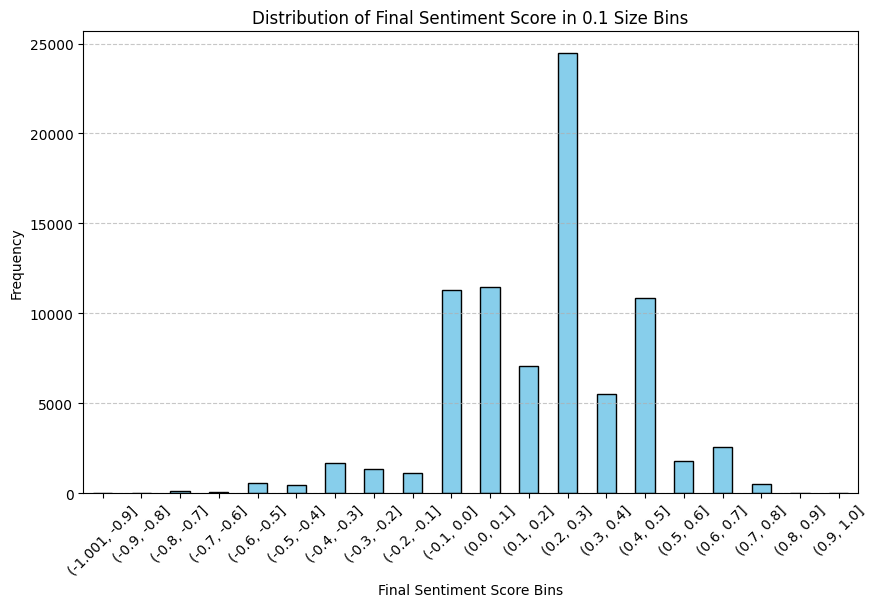

final_sentiment_score
(-1.001, -0.9]        2
(-0.9, -0.8]          0
(-0.8, -0.7]        117
(-0.7, -0.6]         83
(-0.6, -0.5]        579
(-0.5, -0.4]        439
(-0.4, -0.3]       1695
(-0.3, -0.2]       1335
(-0.2, -0.1]       1136
(-0.1, 0.0]       11280
(0.0, 0.1]        11474
(0.1, 0.2]         7059
(0.2, 0.3]        24452
(0.3, 0.4]         5531
(0.4, 0.5]        10875
(0.5, 0.6]         1827
(0.6, 0.7]         2564
(0.7, 0.8]          506
(0.8, 0.9]            2
(0.9, 1.0]            4
Name: count, dtype: int64


In [15]:
import matplotlib.pyplot as plt

# Calculate binning of 'final_sentiment_score' in bins of size 0.1
bin_counts = pd.cut(merged_df['final_sentiment_score'], bins=[i/10 for i in range(-10, 11)], include_lowest=True).value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Final Sentiment Score in 0.1 Size Bins')
plt.xlabel('Final Sentiment Score Bins')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display the bin counts
print(bin_counts)

In [16]:
def classify_sentiment_final(score):
    # Since no specific threshold is provided, let's assume a default for demonstration
    if -0.05 <= score <= 0.3:
        return 'neutral'
    elif score > 0.1:
        return 'positive'
    else:
        return 'negative'
merged_df['final_sentiment_label'] = merged_df['final_sentiment_score'].apply(classify_sentiment_final)
merged_df['final_sentiment_label'].value_counts()

final_sentiment_label
neutral     53180
positive    21309
negative    10006
Name: count, dtype: int64

In [17]:
merged_df[merged_df['others_agree_with_LLM']==True]['final_sentiment_label'].value_counts()

final_sentiment_label
neutral     46203
positive     4935
negative     2570
Name: count, dtype: int64

In [20]:
merged_df = merged_df.drop(columns=['V-9', 'T-9', 'S-9'])

merged_df.to_csv("../data/IMDA_session2_merged_rule_n_GPT4o.csv",index=False)

In [21]:
agreed_df = merged_df[merged_df['others_agree_with_LLM']==True]
agreed_df[agreed_df['final_sentiment_label']=='negative'].sort_values(by='final_sentiment_score')['cleaned_text_for_sentiment'].head().values

array(["I accidentally signed up with a scam (um) company that brought me on a tour and I ended up losing most of my belongings and I'm quite panic right now and I don't know how to go about this process",
       "and then my bumper came off (ppb) and then (ppb) it's a very bad accident I do not know what to do now",
       'and so even if you do your work in the living room sometime the signal will be very bad',
       "and worst case scenario they'll probably give us a fake passport",
       "[oh] ya actually there's flight delay of about one hour (ppb) thirty minute because there was a very bad thunderstorm"],
      dtype=object)